# Twitter Sentiment Analysis of ICC 2019

The [ICC](https://en.wikipedia.org/wiki/International_Champions_Cup) is an annual club association football exhibition competition in which some of the world's top soccer clubs take part. This year, games will be played in several cities around the globe - of which Singapore is one. 

One of the teams that will be playing here in Singapore is [Manchester United FC](https://en.wikipedia.org/wiki/Manchester_United_F.C.), one of the most well-known, highest-earning and accomplished football teams of all time. The [Manchester United twitter account](https://twitter.com/ManUtd) has a staggering 20 million followers, at the time of this project. This extremely large Twitter following is why this team will be focused on in this project.

With the mounting excitement and anticipation around the games among football fans, I decided to use the Twitter API to extract tweets pertaining specifically to Manchester United, and also to ICC 2019 overall to gain information on fan sentiments surrounding the games. 

This analysis will be performed using R (Jupyter Notebook environment will be used to run an R-kernel). We'll start by loading the libraries we'll be using.

In [165]:
library(e1071)
library(wordcloud)
library(dplyr)
library(ggplot2)
library(stringr)
library(tm)
library(tidyr)
library(qdap)
library(caret)
library(purrr)
library(syuzhet)
library(readr)
library(twitteR)
library(plotly)
library(SnowballC)

Warning message:
"package 'caret' was built under R version 3.6.1"Loading required package: lattice

Attaching package: 'caret'

The following object is masked from 'package:purrr':

    lift



## Connecting to the Twitter API 

We'll connect to the Twitter API. Let's start by setting the variables for the Twitter Call authorization. 

Note that the token and key values below have been redacted to prevent unauthorized access to the APIs:

In [2]:
consumer_key <- "redacted key"
consumer_secret <- "redacted consumer"
access_token <- "redacted token"
access_secret <- "redacted secret"
options(httr_oauth_cache=T) 

We'll now use the following command to enable the use of a local file to cache OAuth access credentials between R sessions.

In [3]:
setup_twitter_oauth(consumer_key, consumer_secret, access_token, access_secret)

[1] "Using direct authentication"


Registered S3 method overwritten by 'openssl':
  method      from
  print.bytes Rcpp


## Searching the Twitter API using relevant Hashtags

Because we're interested in Fan sentiments surrounding Manchester United and the ICC 2019 matches we'll extract tweets with the following Hashtags:
1. #ManUtd
2. #ICC2019

We'll only look at tweets from July 2019 onwards, and collect 2000 tweets for each hashtag.

In [4]:
manu_search <- searchTwitter('#ManUtd', n=2000, since='2019-07-01')

In [5]:
icc_search <- searchTwitter('#ICC2019', n=2000, since='2019-07-01')

We'll store the tweet data above as RDS files. 

In [6]:
saveRDS(manu_search, 'manutd.rds')
saveRDS(icc_search, 'icc2019.rds')

The `manutd.rds` and `icc2019.rds` files above will be read, and then converted into a dataframe (which will be more easily manipulated and worked with).

In [7]:
manu_rds <- readRDS('manutd.rds')
manu_tweets <- twListToDF(manu_rds)

icc_rds <- readRDS('icc2019.rds')
icc_tweets <- twListToDF(icc_rds)

## Cleaning the tweets

Let's preview the above `manu_tweets` and `icc_tweets` dataframe.

In [9]:
head(manu_tweets, 3)

head(icc_tweets, 3)

text,favorited,favoriteCount,replyToSN,created,truncated,replyToSID,id,replyToUID,statusSource,screenName,retweetCount,isRetweet,retweeted,longitude,latitude
A clear choice! <U+0001F62F> Reports suggest @paulpogba has his heart set on a @realmadrid move for one key reason. #Pogba… https://t.co/KGioo2e93M,FALSE,0,NA,2019-07-20 02:59:44,TRUE,NA,1152412747155431424,NA,"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",FOXSportsAsia,0,FALSE,FALSE,NA,NA
What #Manchester United want from Fred this season #ManUtd <U+0001F3F4><U+000E0067><U+000E0062><U+000E0065><U+000E006E><U+000E0067><U+000E007F> #Premier_League Pls RT https://t.co/TgNfVy0vYO,FALSE,0,NA,2019-07-20 02:58:41,FALSE,NA,1152412481475796994,NA,"<a href=""https://footy90.com"" rel=""nofollow"">footy90.com - News</a>",footy90com,0,FALSE,FALSE,NA,NA
Betting Odds #football #ChampionsLeague #EuropaLeague #LeedsUnited #ManUtd #freebets #Betfair #Bet365 #Golf £100… https://t.co/WmtIPcfdDn,FALSE,0,NA,2019-07-20 02:42:05,TRUE,NA,1152408304368439296,NA,"<a href=""https://postcron.com"" rel=""nofollow"">Postcron App</a>",SuperLeague77,0,FALSE,FALSE,NA,NA


text,favorited,favoriteCount,replyToSN,created,truncated,replyToSID,id,replyToUID,statusSource,screenName,retweetCount,isRetweet,retweeted,longitude,latitude
"RT @SGSportsHub: Coooooool shot, @ManUtd <U+0001F609> Welcome to #sgsportshub! #ICCSG #ICC2019 https://t.co/78DbPWAqkA",FALSE,0,NA,2019-07-20 03:03:04,FALSE,NA,1152413586167193601,NA,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",PremLovesMusic,1,TRUE,FALSE,NA,NA
"RT @SpursOfficial: <U+0001F605> ""You trying to show off your muscles?"" #SpursTour2019 <U+26AA><U+FE0F> #ICC2019 https://t.co/vJn0ddNH85",FALSE,0,NA,2019-07-20 03:02:59,FALSE,NA,1152413566298759169,NA,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",mzs_mn_11,204,TRUE,FALSE,NA,NA
"Coooooool shot, @ManUtd <U+0001F609> Welcome to #sgsportshub! #ICCSG #ICC2019 https://t.co/78DbPWAqkA",FALSE,0,NA,2019-07-20 03:02:54,FALSE,NA,1152413544194822144,NA,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",SGSportsHub,1,FALSE,FALSE,NA,NA


Because both dataframes were mined using Twitter APIs, they have the same data structure and thus can both be cleaned the same way.

### Removing Special Characters


We see that the `text` columns have many special characters. We will remove these special characters and emojis from our `manu_tweets` and `icc_tweets` dataframes by using the [sapply()](https://www.rdocumentation.org/packages/memisc/versions/0.99.17.2/topics/Sapply), and the [iconv()](https://www.rdocumentation.org/packages/base/versions/3.6.0/topics/iconv) functions.

We will follow this action with even further data-cleaning in a later step.

In [10]:
manu_tweets$text <- sapply(manu_tweets$text,function(row) iconv(row, "latin1", "ASCII", sub=""))
icc_tweets$text <- sapply(icc_tweets$text,function(row) iconv(row, "latin1", "ASCII", sub=""))

Let's preview the dataframes again.

In [11]:
head(manu_tweets,3)

head(icc_tweets,3)

text,favorited,favoriteCount,replyToSN,created,truncated,replyToSID,id,replyToUID,statusSource,screenName,retweetCount,isRetweet,retweeted,longitude,latitude
A clear choice! Reports suggest @paulpogba has his heart set on a @realmadrid move for one key reason. #Pogba https://t.co/KGioo2e93M,FALSE,0,NA,2019-07-20 02:59:44,TRUE,NA,1152412747155431424,NA,"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",FOXSportsAsia,0,FALSE,FALSE,NA,NA
What #Manchester United want from Fred this season #ManUtd #Premier_League Pls RT https://t.co/TgNfVy0vYO,FALSE,0,NA,2019-07-20 02:58:41,FALSE,NA,1152412481475796994,NA,"<a href=""https://footy90.com"" rel=""nofollow"">footy90.com - News</a>",footy90com,0,FALSE,FALSE,NA,NA
Betting Odds #football #ChampionsLeague #EuropaLeague #LeedsUnited #ManUtd #freebets #Betfair #Bet365 #Golf 100 https://t.co/WmtIPcfdDn,FALSE,0,NA,2019-07-20 02:42:05,TRUE,NA,1152408304368439296,NA,"<a href=""https://postcron.com"" rel=""nofollow"">Postcron App</a>",SuperLeague77,0,FALSE,FALSE,NA,NA


text,favorited,favoriteCount,replyToSN,created,truncated,replyToSID,id,replyToUID,statusSource,screenName,retweetCount,isRetweet,retweeted,longitude,latitude
"RT @SGSportsHub: Coooooool shot, @ManUtd Welcome to #sgsportshub! #ICCSG #ICC2019 https://t.co/78DbPWAqkA",FALSE,0,NA,2019-07-20 03:03:04,FALSE,NA,1152413586167193601,NA,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",PremLovesMusic,1,TRUE,FALSE,NA,NA
"RT @SpursOfficial: ""You trying to show off your muscles?"" #SpursTour2019 #ICC2019 https://t.co/vJn0ddNH85",FALSE,0,NA,2019-07-20 03:02:59,FALSE,NA,1152413566298759169,NA,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",mzs_mn_11,204,TRUE,FALSE,NA,NA
"Coooooool shot, @ManUtd Welcome to #sgsportshub! #ICCSG #ICC2019 https://t.co/78DbPWAqkA",FALSE,0,NA,2019-07-20 03:02:54,FALSE,NA,1152413544194822144,NA,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",SGSportsHub,1,FALSE,FALSE,NA,NA


### Determining Device Type

We'll also visualize the frequency with which each Device (Android, iPhone, Web Client, etc) was used to make a tweet.

The `statusSource` columns contain this information. Let's review the `statusSource` columns a little closer:

In [12]:
head(manu_tweets[,"statusSource", drop=FALSE],10)
head(icc_tweets[,"statusSource", drop=FALSE],10)

statusSource
"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>"
"<a href=""https://footy90.com"" rel=""nofollow"">footy90.com - News</a>"
"<a href=""https://postcron.com"" rel=""nofollow"">Postcron App</a>"
"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>"
"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>"
"<a href=""http://instagram.com"" rel=""nofollow"">Instagram</a>"
"<a href=""https://mobile.twitter.com"" rel=""nofollow"">Twitter Web App</a>"
"<a href=""https://www.botlivepsg.com"" rel=""nofollow"">PSGBotLive</a>"
"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>"
"<a href=""https://footyzone.net/"" rel=""nofollow"">Footy News</a>"


statusSource
"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>"
"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>"
"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>"
"<a href=""https://mobile.twitter.com"" rel=""nofollow"">Twitter Web App</a>"
"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>"
"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>"
"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>"
"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>"
"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>"
"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>"


We see that the Device type is always enveloped by HTML code, beginning with `<a href = "url here">`, and then with `</a>` at the end. Let's clean these columns, and assign the cleaned result to a new column, `statusSource_clean`, in each of our two dataframes.

In [13]:
# 'manu_tweets' cleaning:

isolated_device_col <- manu_tweets["statusSource"]

split_device <- str_split_fixed(isolated_device_col$statusSource, ">", n = 2)

device_types <- str_split_fixed((split_device[,2]),"<",n=2)

manu_tweets$statusSource_clean <- device_types[,1]

head(manu_tweets['statusSource_clean'])


# 'icc_tweets' cleaning:

isolated_device_col_2 <- icc_tweets["statusSource"]

split_device2 <- str_split_fixed(isolated_device_col_2$statusSource, ">", n = 2)

device_types <- str_split_fixed((split_device2[,2]),"<",n=2)

icc_tweets$statusSource_clean <- device_types[,1]

head(icc_tweets['statusSource_clean'])

statusSource_clean
TweetDeck
footy90.com - News
Postcron App
Twitter Web Client
TweetDeck
Instagram


statusSource_clean
Twitter for iPhone
Twitter for iPhone
Twitter for iPhone
Twitter Web App
Twitter for Android
Twitter for Android


We see above that the newly made `statusSource_clean` columns look just as we want them to. 

This concludes most of the data cleaning that was necesary for now (although we will still perform more data-cleaning when creating the word corpuses later). 

## Tweet visualization

With the data cleaning out of the way, we can proceed to visualize some of the columns we worked on cleaning before.

### Tweets by Device Type

Let's have a look at the Tweets by device type.

In [9]:
par(mar = c(3, 3, 2, 2))

Depending on the number of Device Types there are, we might have to filter some out to have a more useful visualization. Let's look at the unique device types:

In [14]:
print(length(unique(manu_tweets$statusSource_clean)))

unique(manu_tweets$statusSource_clean)

print(length(unique(icc_tweets$statusSource_clean)))

unique(icc_tweets$statusSource_clean)

[1] 48


[1] "TweetDeck"                     "footy90.com - News"           
 [3] "Postcron App"                  "Twitter Web Client"           
 [5] "Instagram"                     "Twitter Web App"              
 [7] "PSGBotLive"                    "Twitter for Android"          
 [9] "Footy News"                    "Twitter for iPhone"           
[11] "twittbot.net"                  "sportpeda"                    
[13] "ManUtd_PL"                     "Hootsuite Inc."               
[15] "Twitter for iPad"              "Zapier.com"                   
[17] "IFTTT"                         "The Kitman Football Shirts"   
[19] "dlvr.it"                       "ManchesterUnited442"          
[21] "Buffer"                        "TweetCaster for Android"      
[23] "Red Devils Chat"               "Sprout Social"                
[25] "The Social Jukebox"            "VIC Pro"                      
[27] "Article Tweetbot"              "AgoraPulse Manager"           
[29] "Echofon"                       "SoccernewsNL"                 
[31] "Info fifa"                     "Twitter Ads Composer"         
[33] "Echofon  Android"              "PullStatistics"               
[35] "Send a retweet"                "Twitter for BlackBerry"       
[37] "Tweetbot for Mac"              "Blog2Social APP"              
[39] "T7 App"                        "Wp Tweet Machine Femeskit.com"
[41] "Plume for Android"             "first ever test"              
[43] "Tweetbot for i<U+039F>S"       "Mobile Web (M2)"              
[45] "Twitter Mobile App v8.09.81"   "Bot Libre!"                   
[47] "Mention "                      "Bananarama007"

[1] 24


[1] "Twitter for iPhone"              "Twitter Web App"                
 [3] "Twitter for Android"             "Hootsuite Inc."                 
 [5] "Twitter Web Client"              "Twitter for iPad"               
 [7] "Mobile Web (M2)"                 "Echobox Social"                 
 [9] "Sprout Social"                   "TweetDeck"                      
[11] "Falcon Social Media Management " "T7 App"                         
[13] "Man United Memorabilia"          "Twitter for BlackBerry"         
[15] "sportpeda"                       "Instagram"                      
[17] "WordPress.com"                   "TaylorNewsHub"                  
[19] "Twitter Media Studio"            "TweetCaster for Android"        
[21] "Sprinklr"                        "News4UDC bot"                   
[23] "TweetFromMethode"                "IFTTT"

There are a total of 48 Device types for `manu_tweets`, and 24 Device Types for `icc_tweets`. Let's try visualizing this:

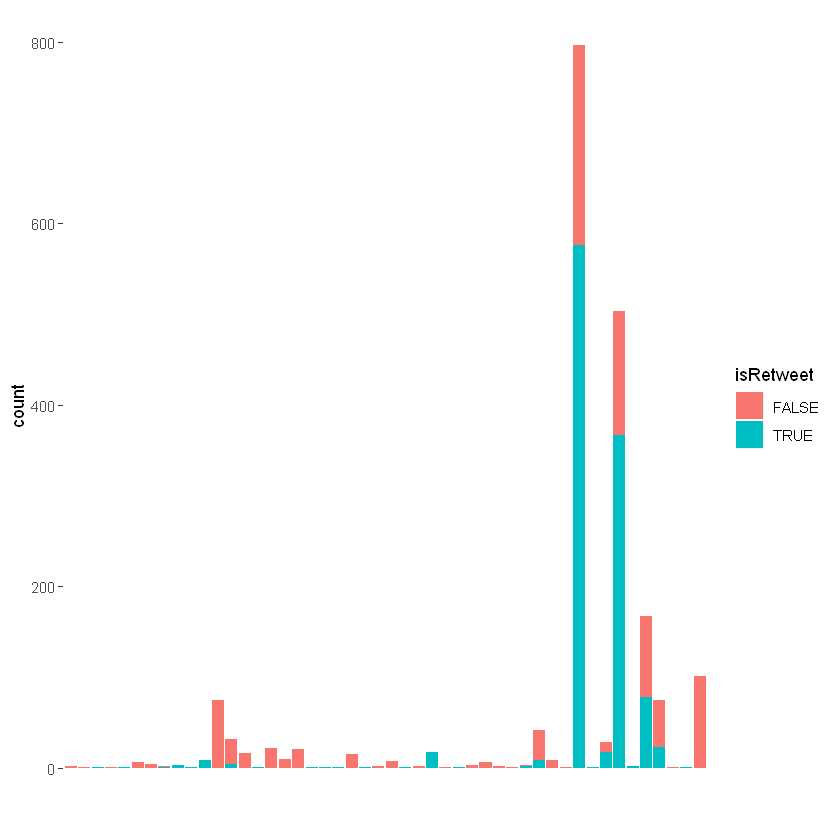

In [15]:
device_types_manu <- (ggplot(manu_tweets, aes(x= statusSource_clean , fill = isRetweet)) + geom_bar() 
                 + theme(panel.background=element_rect(fill='white'), 
                         axis.ticks.x=element_blank(),
                         axis.text.x=element_blank())
                         +labs(x=""))

device_types_manu

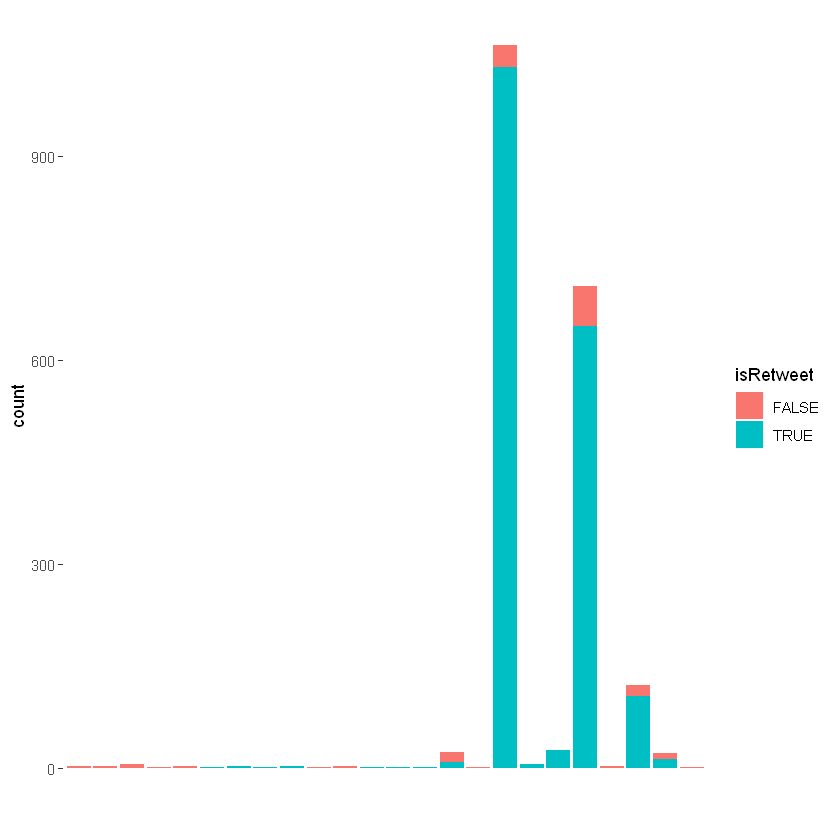

In [16]:
device_types_icc <- (ggplot(icc_tweets, aes(x= statusSource_clean , fill = isRetweet)) + geom_bar() 
                 + theme(panel.background=element_rect(fill='white'), 
                         axis.ticks.x=element_blank(),
                         axis.text.x=element_blank())
                         +labs(x=""))

device_types_icc

We see above that for both graphs, there are 2 Device Types that dominate the graph, and another 5-7 or so that are used less commonly, while the majority of the 48 or 24 device types are used very little. Let's only look at the 10 most popular Device Types in each dataframe, since these account for well over 95% of the tweets in both cases.

In [24]:
# 'manu_tweets' filtering:

freq_table <- as.data.frame(table(manu_tweets$statusSource_clean)) 

freq_table_sorted <- freq_table %>% arrange(desc(Freq))

top_10_devices_freq_manu <-  freq_table_sorted[1:10,]

# Creating a Vector to store the names of the most common 10 devices

top_10_devices_manu <- as.vector(top_10_devices_freq_manu[,1])

top_10_devices_manu




# 'icc_tweets' filtering:

freq_table <- as.data.frame(table(icc_tweets$statusSource_clean)) 

freq_table_sorted <- freq_table %>% arrange(desc(Freq))

top_10_devices_freq_icc <-  freq_table_sorted[1:8,]

# Creating a Vector to store the names of the most common 10 devices

top_10_devices_icc <- as.vector(top_10_devices_freq_icc[,1])

top_10_devices_icc

[1] "Twitter for Android" "Twitter for iPhone"  "Twitter Web App"    
 [4] "Zapier.com"          "footy90.com - News"  "Twitter Web Client" 
 [7] "TweetDeck"           "Hootsuite Inc."      "Twitter for iPad"   
[10] "Instagram"

[1] "Twitter for Android"    "Twitter for iPhone"     "Twitter Web App"       
[4] "Twitter for iPad"       "TweetDeck"              "Twitter Web Client"    
[7] "Hootsuite Inc."         "Twitter for BlackBerry"

In [25]:
manu_tweets2 <- manu_tweets

# Filtering manu_tweets2 to only retain rows where 'statusSource_clean' value matches a value 
# in the above 'top_10_devices_manu' vector.

manu_tweets3 <- manu_tweets2[manu_tweets2$statusSource_clean %in% top_10_devices_manu,]

head(manu_tweets3, 3)



icc_tweets2 <- icc_tweets

# Filtering icc_tweets2 to only retain rows where 'statusSource_clean' value matches a value 
# in the above 'top_10_devices_icc' vector.

icc_tweets3 <- icc_tweets2[icc_tweets2$statusSource_clean %in% top_10_devices_icc,]

head(icc_tweets3, 3)

,text,favorited,favoriteCount,replyToSN,created,truncated,replyToSID,id,replyToUID,statusSource,screenName,retweetCount,isRetweet,retweeted,longitude,latitude,statusSource_clean
1,A clear choice! Reports suggest @paulpogba has his heart set on a @realmadrid move for one key reason. #Pogba https://t.co/KGioo2e93M,FALSE,0,NA,2019-07-20 02:59:44,TRUE,NA,1152412747155431424,NA,"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",FOXSportsAsia,0,FALSE,FALSE,NA,NA,TweetDeck
2,What #Manchester United want from Fred this season #ManUtd #Premier_League Pls RT https://t.co/TgNfVy0vYO,FALSE,0,NA,2019-07-20 02:58:41,FALSE,NA,1152412481475796994,NA,"<a href=""https://footy90.com"" rel=""nofollow"">footy90.com - News</a>",footy90com,0,FALSE,FALSE,NA,NA,footy90.com - News
4,RT @TheAutoKorrect: Nothing more hype than winning an @TheVFL_ @united_ps4 game in extra time at the 93' mark. Well played to @VFLBrighton,FALSE,0,NA,2019-07-20 02:38:20,FALSE,NA,1152407361690230789,NA,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",TheVFL_,1,TRUE,FALSE,NA,NA,Twitter Web Client


text,favorited,favoriteCount,replyToSN,created,truncated,replyToSID,id,replyToUID,statusSource,screenName,retweetCount,isRetweet,retweeted,longitude,latitude,statusSource_clean
"RT @SGSportsHub: Coooooool shot, @ManUtd Welcome to #sgsportshub! #ICCSG #ICC2019 https://t.co/78DbPWAqkA",FALSE,0,NA,2019-07-20 03:03:04,FALSE,NA,1152413586167193601,NA,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",PremLovesMusic,1,TRUE,FALSE,NA,NA,Twitter for iPhone
"RT @SpursOfficial: ""You trying to show off your muscles?"" #SpursTour2019 #ICC2019 https://t.co/vJn0ddNH85",FALSE,0,NA,2019-07-20 03:02:59,FALSE,NA,1152413566298759169,NA,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",mzs_mn_11,204,TRUE,FALSE,NA,NA,Twitter for iPhone
"Coooooool shot, @ManUtd Welcome to #sgsportshub! #ICCSG #ICC2019 https://t.co/78DbPWAqkA",FALSE,0,NA,2019-07-20 03:02:54,FALSE,NA,1152413544194822144,NA,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",SGSportsHub,1,FALSE,FALSE,NA,NA,Twitter for iPhone


In [26]:
# Creating a new table to visualize Device use by percentage

top_10_devices_freq_manu <- top_10_devices_freq_manu %>% mutate(percentage = Freq/sum(top_10_devices_freq_manu$Freq)*100)

top_10_devices_freq_manu



top_10_devices_freq_icc <- top_10_devices_freq_icc %>% mutate(percentage = Freq/sum(top_10_devices_freq_icc$Freq)*100)

top_10_devices_freq_icc

Var1,Freq,percentage
Twitter for Android,797,43.268187
Twitter for iPhone,503,27.307275
Twitter Web App,167,9.066232
Zapier.com,101,5.483170
footy90.com - News,75,4.071661
Twitter Web Client,75,4.071661
TweetDeck,42,2.280130
Hootsuite Inc.,32,1.737242
Twitter for iPad,28,1.520087
Instagram,22,1.194354


Var1,Freq,percentage
Twitter for Android,1063,53.8500507
Twitter for iPhone,708,35.8662614
Twitter Web App,121,6.1296859
Twitter for iPad,26,1.3171226
TweetDeck,23,1.1651469
Twitter Web Client,21,1.0638298
Hootsuite Inc.,6,0.3039514
Twitter for BlackBerry,6,0.3039514


Let's merge the two frequency tables above with the primary dataframes:

In [58]:
icc_merged <- left_join(icc_tweets3, top_10_devices_freq_icc, by = c("statusSource_clean"="Var1"))

manu_merged <- left_join(manu_tweets3, top_10_devices_freq_manu, by = c("statusSource_clean"="Var1"))

head(icc_merged, 3)

head(manu_merged, 3)

Warning message:
"Column `statusSource_clean`/`Var1` joining character vector and factor, coercing into character vector"Warning message:
"Column `statusSource_clean`/`Var1` joining character vector and factor, coercing into character vector"

text,favorited,favoriteCount,replyToSN,created,truncated,replyToSID,id,replyToUID,statusSource,screenName,retweetCount,isRetweet,retweeted,longitude,latitude,statusSource_clean,Freq,percentage
"RT @SGSportsHub: Coooooool shot, @ManUtd Welcome to #sgsportshub! #ICCSG #ICC2019 https://t.co/78DbPWAqkA",FALSE,0,NA,2019-07-20 03:03:04,FALSE,NA,1152413586167193601,NA,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",PremLovesMusic,1,TRUE,FALSE,NA,NA,Twitter for iPhone,708,35.86626
"RT @SpursOfficial: ""You trying to show off your muscles?"" #SpursTour2019 #ICC2019 https://t.co/vJn0ddNH85",FALSE,0,NA,2019-07-20 03:02:59,FALSE,NA,1152413566298759169,NA,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",mzs_mn_11,204,TRUE,FALSE,NA,NA,Twitter for iPhone,708,35.86626
"Coooooool shot, @ManUtd Welcome to #sgsportshub! #ICCSG #ICC2019 https://t.co/78DbPWAqkA",FALSE,0,NA,2019-07-20 03:02:54,FALSE,NA,1152413544194822144,NA,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",SGSportsHub,1,FALSE,FALSE,NA,NA,Twitter for iPhone,708,35.86626


text,favorited,favoriteCount,replyToSN,created,truncated,replyToSID,id,replyToUID,statusSource,screenName,retweetCount,isRetweet,retweeted,longitude,latitude,statusSource_clean,Freq,percentage
A clear choice! Reports suggest @paulpogba has his heart set on a @realmadrid move for one key reason. #Pogba https://t.co/KGioo2e93M,FALSE,0,NA,2019-07-20 02:59:44,TRUE,NA,1152412747155431424,NA,"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",FOXSportsAsia,0,FALSE,FALSE,NA,NA,TweetDeck,42,2.280130
What #Manchester United want from Fred this season #ManUtd #Premier_League Pls RT https://t.co/TgNfVy0vYO,FALSE,0,NA,2019-07-20 02:58:41,FALSE,NA,1152412481475796994,NA,"<a href=""https://footy90.com"" rel=""nofollow"">footy90.com - News</a>",footy90com,0,FALSE,FALSE,NA,NA,footy90.com - News,75,4.071661
RT @TheAutoKorrect: Nothing more hype than winning an @TheVFL_ @united_ps4 game in extra time at the 93' mark. Well played to @VFLBrighton,FALSE,0,NA,2019-07-20 02:38:20,FALSE,NA,1152407361690230789,NA,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",TheVFL_,1,TRUE,FALSE,NA,NA,Twitter Web Client,75,4.071661


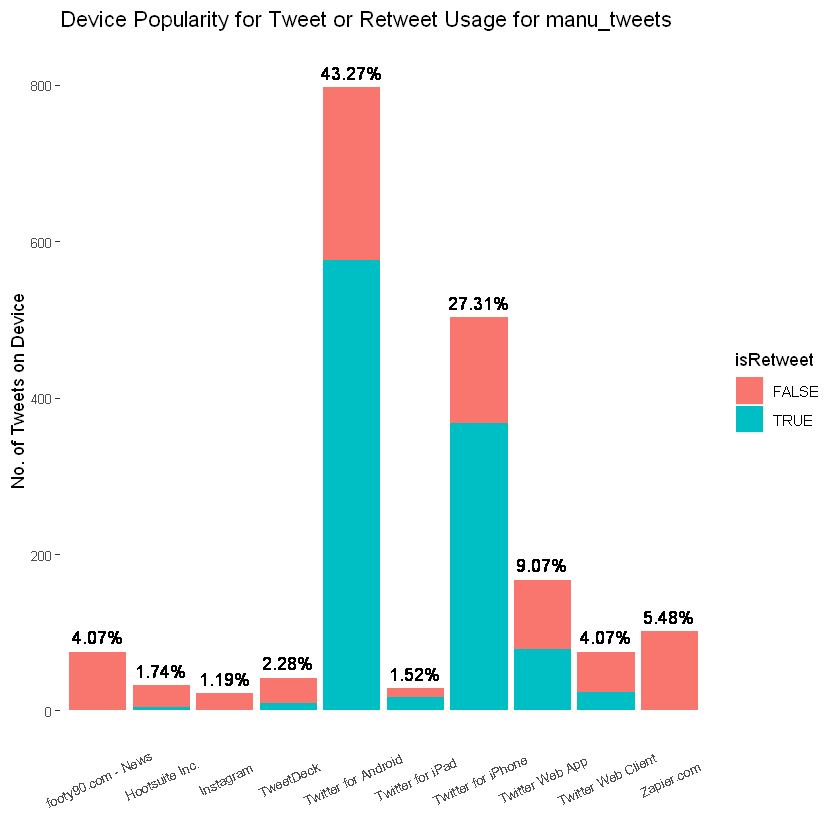

In [60]:
device_types_condensed_manu <- (ggplot(manu_merged, aes(x= statusSource_clean , fill = isRetweet)) + geom_bar() 
                 + theme(panel.background=element_rect(fill='white'), 
                         axis.ticks.x=element_blank(),
                         axis.text.x=element_blank())
                         + theme(axis.ticks.x=element_blank(), axis.text.x = element_text(angle = 25),
                         axis.text=element_text(size=8)) 
                         + labs(x="", title = "Device Popularity for Tweet or Retweet Usage for manu_tweets", y ="No. of Tweets on Device")
                         + geom_text(aes(statusSource_clean, Freq + 20, label = paste0(round(percentage,2), "%") , fill = NULL))
                               )
device_types_condensed_manu

We see above that in the `manu_tweets` dataframe, the Twitter apps for Android and iPhone account for the most tweets. **What's interesting to note is that most of the time a tweet occurs on a mobile app, it is a retweet much more often than not.** On web clients, users are more likely to post original tweets, rather than re-tweet.

Let's visualize device types for the `icc_tweets` dataframe:

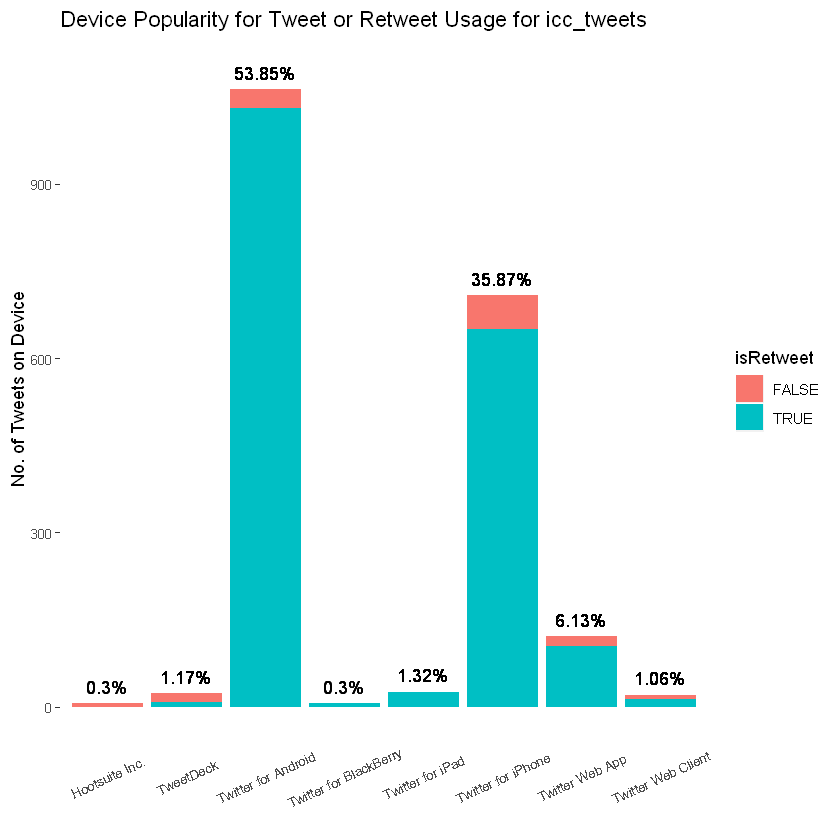

In [57]:
device_types_condensed_icc <- (ggplot(icc_merged, aes(x= statusSource_clean , fill = isRetweet)) + geom_bar() 
                 + theme(panel.background=element_rect(fill='white'), 
                         axis.ticks.x=element_blank(),
                         axis.text.x=element_blank())
                         + theme(axis.ticks.x=element_blank(), axis.text.x = element_text(angle = 25),
                         axis.text=element_text(size=8)) 
                         + labs(x="", title = "Device Popularity for Tweet or Retweet Usage for icc_tweets", y ="No. of Tweets on Device")
                         + geom_text(aes(statusSource_clean, Freq + 30, label = paste0(round(percentage,2), "%") , fill = NULL)))

device_types_condensed_icc

The biggest thing that stands out is that compared to the #ManUTD hashtag, the #ICC2019 hashtag has a significantly higher proportion of re-tweets than original tweets. 

This could be because fans might be more likely to re-tweet about an event, rather than make an original tweet about it, but when it comes to football teams they have emotional investments in, they're more likely to make original tweets.

### Building a Word-cloud

We'll first build a corpus of words from the `texts` columns in `manu_tweets` and `icc_tweets` which we cleaned a bit earlier. We'll clean this column even further to remove all white space, punctuation, any remaining special characters, stop words ("a", "the", "of", etc), and make all letters lower case so there is no distinction between words based on letter casing.

Afterwards, we'll derive 2 wordclouds from the corpus.

We'll begin by writing a function that takes the `texts` column in a table as a corpus, converts it to a word corpus, and does all the necessary processing outlined above using the ['tm_map'](https://www.rdocumentation.org/packages/tm/versions/0.7-6/topics/tm_map) function.

In [184]:
word_corpus_manu <- Corpus(VectorSource(manu_tweets$text))
word_corpus_icc <- Corpus(VectorSource(icc_tweets$text))

corpus_cleaner <- function(corpus){
corpus <- tm_map(corpus, removePunctuation)
corpus <- tm_map(corpus, content_transformer(tolower))
corpus <- tm_map(corpus, removeWords, stopwords("english"))
corpus <- tm_map(corpus, stripWhitespace)
corpus <- tm_map(corpus, stemDocument)
corpus <- corpus[-grep("http", sapply(corpus, `[`, 1))]
}

manu_corpus_final <- corpus_cleaner(word_corpus_manu)
icc_corpus_final <- corpus_cleaner(word_corpus_icc)

Warning message in tm_map.SimpleCorpus(corpus, removePunctuation):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(corpus, content_transformer(tolower)):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(corpus, removeWords, stopwords("english")):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(corpus, stripWhitespace):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(corpus, stemDocument):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(corpus, removePunctuation):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(corpus, content_transformer(tolower)):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(corpus, removeWords, stopwords("english")):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(corpus, stripWhitespace):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(corpus, stemDocument):
"t

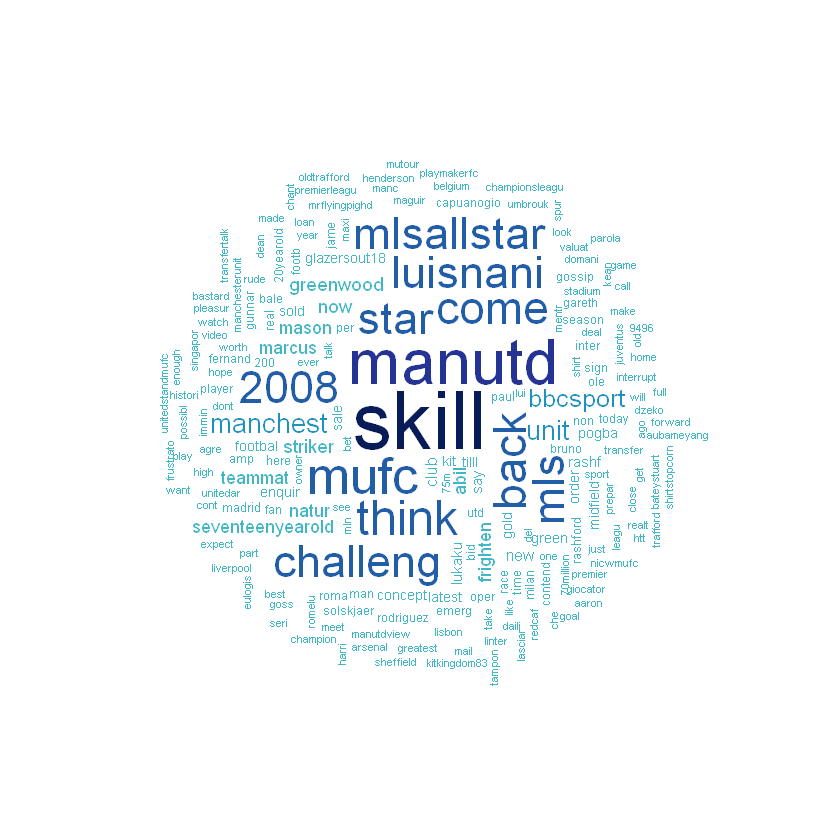

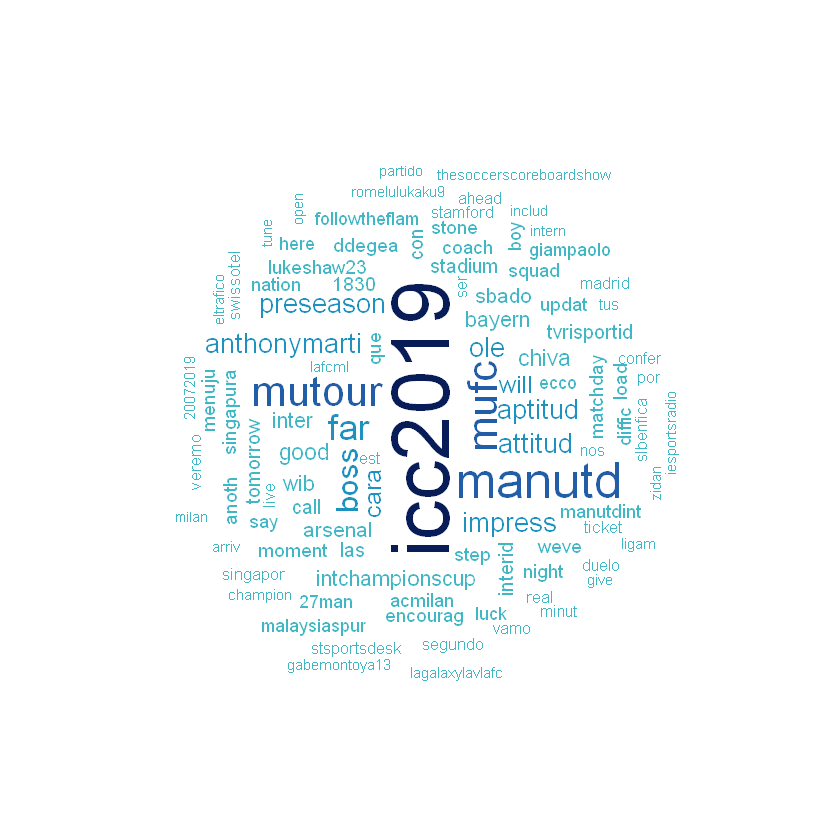

In [185]:
color_scheme <- brewer.pal(9,"YlGnBu")
color_scheme <- color_scheme[-(1:4)]
set.seed(103)
wordcloud(words = manu_corpus_final, max.words=200, random.order=FALSE, 
          rot.per=0.35, use.r.layout=FALSE, colors=color_scheme)

color_scheme <- brewer.pal(9,"YlGnBu")
color_scheme <- color_scheme[-(1:4)]
set.seed(103)
wordcloud(words = icc_corpus_final, max.words=100, random.order=FALSE, 
          rot.per=0.25, use.r.layout=FALSE, colors=color_scheme)

## Sentiment Analysis

The [get_nrc_sentiment()](https://www.rdocumentation.org/packages/syuzhet/versions/1.0.4/topics/get_nrc_sentiment) function from the `syuzhet` library will be used to designate an emotional attribute to our tweets in each dataframe. As outlined in the documentation, this function will call the [NRC sentiment dictionary](http://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm) to calculate the presence of eight different emotions, as well as the overall positive or negative attribute.

The resulting output will then be something that we'll be able to graphically represent.

Let's first test the sentiment analysis from the `get_nrc_sentiment` on one of our tweets:

In [78]:
manu_tweets[101,"text"]

get_nrc_sentiment(manu_tweets[101,"text"])

icc_tweets[101,"text"]

get_nrc_sentiment(icc_tweets[101,"text"])

[1] "RT @red_cafe:  DAILY MAIL: Dean Henderson close to agreeing new Manchester United deal before going back on loan to Sheffield United. Manc"

anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive
0,3,0,0,1,0,1,3,0,4


[1] "RT @ManUtd: 6 goals, 6 seconds \n\nHere's hoping for more #MUTOUR strikes tomorrow! \n\n#MUFC #ICC2019 https://t.co/zsx9jV3Ksq"

anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive
0,1,0,0,0,0,0,0,0,0


We see that the `get_nrc_sentiment` function managed to gather the overall negative gist of their tweet, particularly where there was anticipation.

Let's proceed to get the sentiment analysis of every tweet, and then add the results of each column to see the overall sentiment.

In [79]:
manu_sentiments <- get_nrc_sentiment(manu_tweets$text)

overall_manu_sentiment <- data.frame(colSums(manu_sentiments))

overall_manu_sentiment


icc_sentiments <- get_nrc_sentiment(icc_tweets$text)

overall_icc_sentiment <- data.frame(colSums(icc_sentiments))

overall_icc_sentiment

,colSums.manu_sentiments.
anger,591
anticipation,1604
disgust,86
fear,657
joy,850
sadness,298
surprise,199
trust,1433
negative,887
positive,2116


,colSums.icc_sentiments.
anger,163
anticipation,591
disgust,127
fear,207
joy,356
sadness,231
surprise,233
trust,546
negative,283
positive,602


Let's assign the table above different row and column names, then graphically represent it. RIght now the sentiments are listed as the row names, but we want them as column variables for out purposes.

In [80]:
colnames(overall_manu_sentiment) <- "overall_emotion"

overall_manu_sentiment <- cbind("sentiment" = rownames(overall_manu_sentiment), overall_manu_sentiment)

overall_manu_sentiment



colnames(overall_icc_sentiment) <- "overall_emotion"

overall_icc_sentiment <- cbind("sentiment" = rownames(overall_icc_sentiment), overall_icc_sentiment)

overall_icc_sentiment

,sentiment,overall_emotion
anger,anger,591
anticipation,anticipation,1604
disgust,disgust,86
fear,fear,657
joy,joy,850
sadness,sadness,298
surprise,surprise,199
trust,trust,1433
negative,negative,887
positive,positive,2116


,sentiment,overall_emotion
anger,anger,163
anticipation,anticipation,591
disgust,disgust,127
fear,fear,207
joy,joy,356
sadness,sadness,231
surprise,surprise,233
trust,trust,546
negative,negative,283
positive,positive,602


Let's also re-order the emotions in the following order:

`"joy", "anticipation", "trust", "surprise", "disgust", "fear", "anger", "sadness", "negative", "positive"`

In [82]:
overall_manu_sentiment <- overall_manu_sentiment %>%
  mutate(sentiment = factor(sentiment, levels = c("positive", "joy", "anticipation", "trust", "surprise", "disgust", "fear", "anger", "sadness", "negative")))
  
overall_icc_sentiment <- overall_icc_sentiment %>%
  mutate(sentiment = factor(sentiment, levels = c("positive", "joy", "anticipation", "trust", "surprise", "disgust", "fear", "anger", "sadness", "negative")))
  

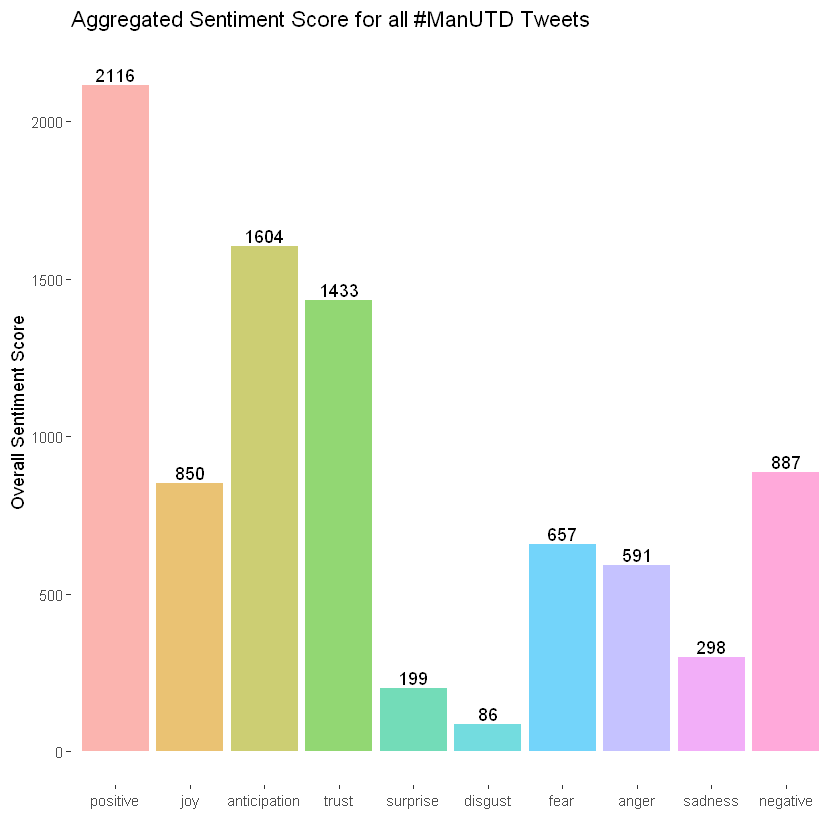

In [83]:
manu_sentiment_graph <- ggplot(data = overall_manu_sentiment, aes(x = sentiment, y = overall_emotion)) +
  geom_bar(aes(fill = sentiment, alpha = 0.8), stat = "identity") +
  labs(x="", y="Overall Sentiment Score", title = "Aggregated Sentiment Score for all #ManUTD Tweets") +
  theme(legend.position = "none", panel.background=element_rect(fill='white')) + 
  geom_text(aes(sentiment, overall_emotion + 35, label = overall_emotion , fill = NULL))
  
  
manu_sentiment_graph

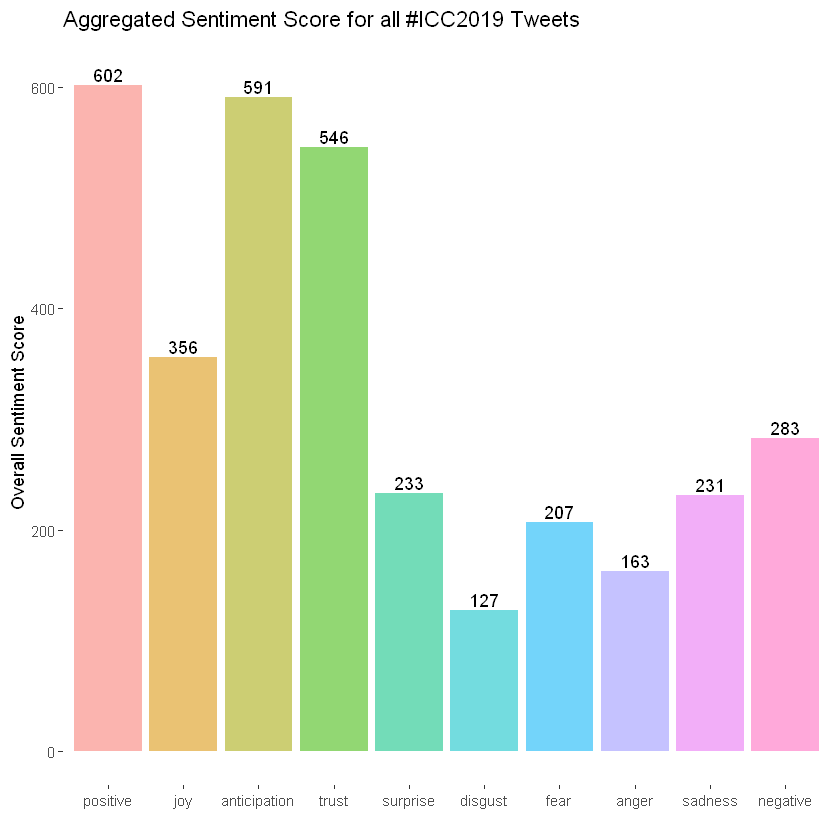

In [88]:
icc_sentiment_graph <- ggplot(data = overall_icc_sentiment, aes(x = sentiment, y = overall_emotion)) +
  geom_bar(aes(fill = sentiment, alpha = 0.8), stat = "identity") +
  labs(x="", y="Overall Sentiment Score", title = "Aggregated Sentiment Score for all #ICC2019 Tweets") +
  theme(legend.position = "none", panel.background=element_rect(fill='white')) + 
  geom_text(aes(sentiment, overall_emotion + 10, label = overall_emotion , fill = NULL))
  
  
icc_sentiment_graph

Both graphs follow very similar trends, with positively associated emotions - particularly `joy` and `anticipation`, scoring very highly.

## Naieve Bayes Predictive Modelling

### Adding Column to measure Overall Sentiment

Let's add 3 columns to the `manu_tweets` and `icc_tweets` dataframes. We want a column for:
1. positive sentiment score, 
2. negative sentiment score,
3. for which sentiment (i.e. positive or negative) is greater.

This essentially assigns an overall sentiment, i.e. positive or negative, to each tweet.

We'll start by adding the first two columns for only positive and negative sentiment scores:

In [110]:
manu_tweets$positive <- manu_sentiments$positive
manu_tweets$negative <- manu_sentiments$negative

icc_tweets$positive <- icc_sentiments$positive
icc_tweets$negative <- icc_sentiments$negative

head(manu_tweets, 3)
head(icc_tweets, 3)

text,favorited,favoriteCount,replyToSN,created,truncated,replyToSID,id,replyToUID,statusSource,screenName,retweetCount,isRetweet,retweeted,longitude,latitude,statusSource_clean,positive,negative
A clear choice! Reports suggest @paulpogba has his heart set on a @realmadrid move for one key reason. #Pogba https://t.co/KGioo2e93M,FALSE,0,NA,2019-07-20 02:59:44,TRUE,NA,1152412747155431424,NA,"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",FOXSportsAsia,0,FALSE,FALSE,NA,NA,TweetDeck,2,0
What #Manchester United want from Fred this season #ManUtd #Premier_League Pls RT https://t.co/TgNfVy0vYO,FALSE,0,NA,2019-07-20 02:58:41,FALSE,NA,1152412481475796994,NA,"<a href=""https://footy90.com"" rel=""nofollow"">footy90.com - News</a>",footy90com,0,FALSE,FALSE,NA,NA,footy90.com - News,3,0
Betting Odds #football #ChampionsLeague #EuropaLeague #LeedsUnited #ManUtd #freebets #Betfair #Bet365 #Golf 100 https://t.co/WmtIPcfdDn,FALSE,0,NA,2019-07-20 02:42:05,TRUE,NA,1152408304368439296,NA,"<a href=""https://postcron.com"" rel=""nofollow"">Postcron App</a>",SuperLeague77,0,FALSE,FALSE,NA,NA,Postcron App,1,0


text,favorited,favoriteCount,replyToSN,created,truncated,replyToSID,id,replyToUID,statusSource,screenName,retweetCount,isRetweet,retweeted,longitude,latitude,statusSource_clean,positive,negative
"RT @SGSportsHub: Coooooool shot, @ManUtd Welcome to #sgsportshub! #ICCSG #ICC2019 https://t.co/78DbPWAqkA",FALSE,0,NA,2019-07-20 03:03:04,FALSE,NA,1152413586167193601,NA,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",PremLovesMusic,1,TRUE,FALSE,NA,NA,Twitter for iPhone,0,1
"RT @SpursOfficial: ""You trying to show off your muscles?"" #SpursTour2019 #ICC2019 https://t.co/vJn0ddNH85",FALSE,0,NA,2019-07-20 03:02:59,FALSE,NA,1152413566298759169,NA,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",mzs_mn_11,204,TRUE,FALSE,NA,NA,Twitter for iPhone,0,0
"Coooooool shot, @ManUtd Welcome to #sgsportshub! #ICCSG #ICC2019 https://t.co/78DbPWAqkA",FALSE,0,NA,2019-07-20 03:02:54,FALSE,NA,1152413544194822144,NA,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",SGSportsHub,1,FALSE,FALSE,NA,NA,Twitter for iPhone,0,1


Now, we add the 3rd column for overall sentiment.

If the negative score is more than the positive score, the tweet is `negative`. Otherwise, the tweet is `positive`. 

Tweets with an equal positive and negative sentiment are assigned to positive, because of the overall dominance of positive sentiments.

In [116]:
manu_tweets <- manu_tweets %>% mutate(sentiment = ifelse(positive >= negative, "positive", "negative"))
icc_tweets <- icc_tweets %>% mutate(sentiment = ifelse(positive >= negative, "positive", "negative"))

head(manu_tweets,5)
head(icc_tweets,3)

text,favorited,favoriteCount,replyToSN,created,truncated,replyToSID,id,replyToUID,statusSource,screenName,retweetCount,isRetweet,retweeted,longitude,latitude,statusSource_clean,positive,negative,sentiment
A clear choice! Reports suggest @paulpogba has his heart set on a @realmadrid move for one key reason. #Pogba https://t.co/KGioo2e93M,FALSE,0,NA,2019-07-20 02:59:44,TRUE,NA,1152412747155431424,NA,"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",FOXSportsAsia,0,FALSE,FALSE,NA,NA,TweetDeck,2,0,positive
What #Manchester United want from Fred this season #ManUtd #Premier_League Pls RT https://t.co/TgNfVy0vYO,FALSE,0,NA,2019-07-20 02:58:41,FALSE,NA,1152412481475796994,NA,"<a href=""https://footy90.com"" rel=""nofollow"">footy90.com - News</a>",footy90com,0,FALSE,FALSE,NA,NA,footy90.com - News,3,0,positive
Betting Odds #football #ChampionsLeague #EuropaLeague #LeedsUnited #ManUtd #freebets #Betfair #Bet365 #Golf 100 https://t.co/WmtIPcfdDn,FALSE,0,NA,2019-07-20 02:42:05,TRUE,NA,1152408304368439296,NA,"<a href=""https://postcron.com"" rel=""nofollow"">Postcron App</a>",SuperLeague77,0,FALSE,FALSE,NA,NA,Postcron App,1,0,positive
RT @TheAutoKorrect: Nothing more hype than winning an @TheVFL_ @united_ps4 game in extra time at the 93' mark. Well played to @VFLBrighton,FALSE,0,NA,2019-07-20 02:38:20,FALSE,NA,1152407361690230789,NA,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",TheVFL_,1,TRUE,FALSE,NA,NA,Twitter Web Client,3,1,positive
Gone too early? Stats indicate @ManUtd might end up making a BIG mistake if they let go of Romelu Lukaku. https://t.co/eV8ug1jGId,FALSE,3,NA,2019-07-20 02:29:32,TRUE,NA,1152405148586483713,NA,"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",FOXSportsAsia,0,FALSE,FALSE,NA,NA,TweetDeck,0,1,negative


text,favorited,favoriteCount,replyToSN,created,truncated,replyToSID,id,replyToUID,statusSource,screenName,retweetCount,isRetweet,retweeted,longitude,latitude,statusSource_clean,positive,negative,sentiment
"RT @SGSportsHub: Coooooool shot, @ManUtd Welcome to #sgsportshub! #ICCSG #ICC2019 https://t.co/78DbPWAqkA",FALSE,0,NA,2019-07-20 03:03:04,FALSE,NA,1152413586167193601,NA,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",PremLovesMusic,1,TRUE,FALSE,NA,NA,Twitter for iPhone,0,1,negative
"RT @SpursOfficial: ""You trying to show off your muscles?"" #SpursTour2019 #ICC2019 https://t.co/vJn0ddNH85",FALSE,0,NA,2019-07-20 03:02:59,FALSE,NA,1152413566298759169,NA,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",mzs_mn_11,204,TRUE,FALSE,NA,NA,Twitter for iPhone,0,0,positive
"Coooooool shot, @ManUtd Welcome to #sgsportshub! #ICCSG #ICC2019 https://t.co/78DbPWAqkA",FALSE,0,NA,2019-07-20 03:02:54,FALSE,NA,1152413544194822144,NA,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",SGSportsHub,1,FALSE,FALSE,NA,NA,Twitter for iPhone,0,1,negative


Additionally, we'll also convert the newly added`sentiment` variable from character to factor:

In [117]:
manu_tweets$sentiment <- as.factor(manu_tweets$sentiment)
icc_tweets$sentiment <- as.factor(icc_tweets$sentiment)

### Creating Document Term Matrix for representation of Words

Then, we'll construct a corpus for each dataframe. 

We'll also use a variant of the `corpus_cleaner` function from before to clean the corpus. This new function will also remove the numbers.

In [121]:
manu_corpus <- Corpus(VectorSource(manu_tweets$text))
icc_corpus <- Corpus(VectorSource(icc_tweets$text))

corpus_cleaner2 <- function(corpus){
corpus <- tm_map(corpus, removePunctuation)
corpus <- tm_map(corpus, content_transformer(tolower))
corpus <- tm_map(corpus, removeWords, stopwords("english"))
corpus <- tm_map(corpus, removeNumbers)
corpus <- tm_map(corpus, stripWhitespace)
corpus <- tm_map(corpus, stemDocument)
}

manu_corp_clean <- corpus_cleaner2(manu_corpus)
icc_corp_clean <- corpus_cleaner2(icc_corpus)


Warning message in tm_map.SimpleCorpus(corpus, removePunctuation):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(corpus, content_transformer(tolower)):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(corpus, removeWords, stopwords("english")):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(corpus, removeNumbers):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(corpus, stripWhitespace):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(corpus, stemDocument):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(corpus, removePunctuation):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(corpus, content_transformer(tolower)):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(corpus, removeWords, stopwords("english")):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(corpus, removeNumbers):
"tr

We'll represent the words in each corpus with a document term matrix (DTM). The rows of the document term matrix correspond to documents in the collection, the columns correspond to terms, and its elements are the term frequencies.

In [127]:
manu_dtm <- DocumentTermMatrix(manu_corp_clean)
icc_dtm <- DocumentTermMatrix(icc_corp_clean)

inspect(manu_dtm[30:40, 15:20])
inspect(icc_dtm[40:50, 10:15])

<<DocumentTermMatrix (documents: 11, terms: 6)>>
Non-/sparse entries: 12/54
Sparsity           : 82%
Maximal term length: 17
Weighting          : term frequency (tf)
Sample             :
    Terms
Docs fred httpstcotgnfvyvyo manchest manutd pls premierleagu
  30    0                 0        0      1   0            0
  31    0                 0        0      1   0            0
  32    0                 0        0      0   0            0
  33    0                 0        0      1   0            0
  34    0                 0        0      1   0            0
  35    0                 0        0      1   0            0
  36    0                 0        0      1   0            0
  37    0                 0        1      1   0            0
  39    0                 0        1      1   0            0
  40    0                 0        1      1   0            0
<<DocumentTermMatrix (documents: 11, terms: 6)>>
Non-/sparse entries: 4/62
Sparsity           : 94%
Maximal term length: 11
Weightin

### Data Partitioning for train and test sets

Next, we'll create 75:25 partitions of each dataframe, corpus and, document term matrix to create the train and test sets.

In [143]:
#ManUTD:
manu_tweets.train <- manu_tweets[1:1500,]
manu_tweets.test <- manu_tweets[1501:2000,]

manu_dtm.train <- manu_dtm[1:1500,]
manu_dtm.test <- manu_dtm[1501:2000,]

manu_corp_clean.train <- manu_corp_clean[1:1500]
manu_corp_clean.test <- manu_corp_clean[1501:2000]


#ICC2019:
icc_tweets.train <- icc_tweets[1:1500,]
icc_tweets.test <- icc_tweets[1501:2000,]

icc_dtm.train <- icc_dtm[1:1500,]
icc_dtm.test <- icc_dtm[1501:2000,]

icc_corp_clean.train <- icc_corp_clean[1:1500]
icc_corp_clean.test <- icc_corp_clean[1501:2000]

In [144]:
dim(manu_dtm.train)

dim(icc_dtm.train)

[1] 1500 3971

[1] 1500 1466

The DTMs have 3971 and 1466 features respectively. We can reduce the number of features by disregarding words which don't appear in at least 3 unique tweets.

We'll use the `findFreqTerms` function to identify which words don't appear frequently, and then restrict the DTM to only use the frequent words.

In [150]:
manufreq <- findFreqTerms(manu_dtm.train, 3)
length((manufreq))

iccfreq <- findFreqTerms(icc_dtm.train, 3)
length((iccfreq))


# Training sets using words that appear at least 3 times:
manu_dtm.train.nb <- DocumentTermMatrix(manu_corp_clean.train, control=list(dictionary = manufreq))
icc_dtm.train.nb <- DocumentTermMatrix(icc_corp_clean.train, control=list(dictionary = iccfreq))

dim(manu_dtm.train.nb)
dim(icc_dtm.train.nb)

# Testing sets using words that appear at least 3 times:
manu_dtm.test.nb <- DocumentTermMatrix(manu_corp_clean.test, control=list(dictionary = manufreq))
icc_dtm.test.nb <- DocumentTermMatrix(icc_corp_clean.test, control=list(dictionary = iccfreq))

dim(manu_dtm.test.nb)
dim(icc_dtm.test.nb)

[1] 919

[1] 500

[1] 1500  919

[1] 1500  500

[1] 500 919

[1] 500 500

### Binarized Naive Bayes

The Binarized Naive Bayes is a variation of the naive bayes algorithm where the frequency of a given term is replaced by a binary value instead, the logic being that when it comes to sentiment analysis, the *occurrence* of a word matters more than the frequency of said occurrence. 

We'll begin by making a function that converts word presence or absence to a binary value. We'll then apply the function to the existing DTMs to get the final training and testing DTM sets.

In [152]:
binary_convert <- function(x) {
  occurrence <- ifelse(x > 0, 1,0)
  occurrence <- factor(occurrence, levels=c(0,1), labels=c("No", "Yes"))
  occurrence
}

manu_trainNB <- apply(manu_dtm.train.nb, 2, binary_convert)
manu_testNB <- apply(manu_dtm.test.nb, 2, binary_convert)

icc_trainNB <- apply(icc_dtm.train.nb, 2, binary_convert)
icc_testNB <- apply(icc_dtm.test.nb, 2, binary_convert)

### Naive Bayes Model Training

We'll use the `naiveBayes` function to train the models. 

Because Naive Bayes evaluates products of probabilities, we'll use Laplace 1 to assign non-zero probabilities to words which don't occur in the samples.

We'll start by training the classifiers:

In [157]:
system.time(manu_classifier <- naiveBayes(manu_trainNB, manu_tweets.train$sentiment, laplace = 1))

   user  system elapsed 
   0.54    0.05    0.76 

In [158]:
system.time(icc_classifier <- naiveBayes(icc_trainNB, icc_tweets.train$sentiment, laplace = 1))

   user  system elapsed 
   0.28    0.00    0.30 

### Testing the Models

We'll test the classifiers trained above on the `manu_testNB` and `icc_testNB` training sets we made above.

Afterwards we'll construct confusion matrices and determine what the accuracy of each classifier was.

In [159]:
system.time(manu_prediction <- predict(manu_classifier, newdata=manu_testNB))

   user  system elapsed 
   7.78    0.15    8.96 

In [160]:
system.time(icc_prediction <- predict(icc_classifier, newdata=icc_testNB))

   user  system elapsed 
   4.12    0.00    4.12 

### Creating Truth Table

To determine what the prediction accuracy was, we'll create a truth table that tabulates the predicted sentiment label against what the actual sentiment label was.

In [161]:
table("Prediction"= manu_prediction,  "Actual" = manu_tweets.test$sentiment)

          Actual
Prediction negative positive
  negative        8       18
  positive       22      452

In [162]:
table("Prediction"= icc_prediction,  "Actual" = icc_tweets.test$sentiment)

          Actual
Prediction negative positive
  negative       20        8
  positive        5      467

### Creating `manu` Confusion Matrices

In [166]:
manu_confusion_mat <- confusionMatrix(manu_prediction, manu_tweets.test$sentiment)

manu_confusion_mat

Confusion Matrix and Statistics

          Reference
Prediction negative positive
  negative        8       18
  positive       22      452
                                          
               Accuracy : 0.92            
                 95% CI : (0.8927, 0.9422)
    No Information Rate : 0.94            
    P-Value [Acc > NIR] : 0.9719          
                                          
                  Kappa : 0.2436          
                                          
 Mcnemar's Test P-Value : 0.6353          
                                          
            Sensitivity : 0.2667          
            Specificity : 0.9617          
         Pos Pred Value : 0.3077          
         Neg Pred Value : 0.9536          
             Prevalence : 0.0600          
         Detection Rate : 0.0160          
   Detection Prevalence : 0.0520          
      Balanced Accuracy : 0.6142          
                                          
       'Positive' Class : negative        


In [175]:
manu_confusion_mat$overall

manu_confusion_mat$overall['Accuracy']

Accuracy          Kappa  AccuracyLower  AccuracyUpper   AccuracyNull 
     0.9200000      0.2435703      0.8926545      0.9422339      0.9400000 
AccuracyPValue  McnemarPValue 
     0.9718596      0.6352563

Accuracy 
    0.92

### Creating `icc` Confusion Matrices

In [171]:
icc_confusion_mat <- confusionMatrix(icc_prediction, icc_tweets.test$sentiment)

icc_confusion_mat

Confusion Matrix and Statistics

          Reference
Prediction negative positive
  negative       20        8
  positive        5      467
                                          
               Accuracy : 0.974           
                 95% CI : (0.9559, 0.9861)
    No Information Rate : 0.95            
    P-Value [Acc > NIR] : 0.005508        
                                          
                  Kappa : 0.741           
                                          
 Mcnemar's Test P-Value : 0.579100        
                                          
            Sensitivity : 0.8000          
            Specificity : 0.9832          
         Pos Pred Value : 0.7143          
         Neg Pred Value : 0.9894          
             Prevalence : 0.0500          
         Detection Rate : 0.0400          
   Detection Prevalence : 0.0560          
      Balanced Accuracy : 0.8916          
                                          
       'Positive' Class : negative        


In [176]:
icc_confusion_mat$overall

icc_confusion_mat$overall['Accuracy']

Accuracy          Kappa  AccuracyLower  AccuracyUpper   AccuracyNull 
   0.974000000    0.741035857    0.955949563    0.986085070    0.950000000 
AccuracyPValue  McnemarPValue 
   0.005507755    0.579099742

Accuracy 
   0.974

### Outcome of Naive Bayes model

The accuracy of the `icc_classifier` was 97.4%, and that of the `manu_classifier` was 92%. 

We see that the Naive Bayes algorithm did a decent job in analyzes the sentiments of the tweets in the test data, despite the assumptions of the Naive Bayes model.